In [1]:
import copy
import humanize
import math
import matplotlib.pyplot as plt
import os
import subprocess
import sys
import pandas as pd
import time

from ast import literal_eval
from matplotlib.ticker import FuncFormatter
from IPython.display import display, clear_output

In [2]:
# pull in our gquery module and import the config
sys.path.append('../../scripts')
os.environ['GUFI_CONFIG']='/home/jbent/GUFI/configs/anony'
#os.environ['GUFI_DEBUG']='TRUE'
import gquery as gq

config=gq.query_gconfig()
nthreads=config.config['Threads']
indexroot=config.config['IndexRoot']
print(f"Using {nthreads} threads on {indexroot}")

Using 224 threads on /mnt/nvme1n1/jbent/anony


In [3]:
def run_gufi_query(indexroot, nthreads, create_int, insert_int, create_agg, insert_agg, select_agg, Verbose=False):
    cmd = 'gufi_query'
    command = [
        cmd,
        "-I", create_int,
        "-S", insert_int,
        "-K", create_agg,
        "-J", insert_agg,
        "-G", select_agg,
        "-n", nthreads,
        indexroot
    ]
    if Verbose:
        print(f"Running {cmd} on {indexroot} with {nthreads} threads using the following command:")
        print('\n\t'.join([line for line in command]))
    
    start_time = time.time()
    completed_process = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    end_time = time.time()
    
    if completed_process.returncode != 0:
        print(f"An error occurred:\n{completed_process.stderr.decode('utf-8')}")
        return None
    else:
        output = completed_process.stdout.decode('utf-8')
        if Verbose:
            print(f"Output:\n{output}")
            print(f"Elapsed time: {(end_time - start_time)/60:.2f} minutes")
        return output

In [4]:
%%time
# function to find the largest file in an index using the built-in gufi_query aggregation on the summary tables
# note: can do this same thing easily with the vrpentries table instead of summary but this is a bit faster
def largest_file_size(indexroot,nthreads=nthreads,Verbose=True):
    create_int = "CREATE TABLE intermediate (size INT64);"
    create_agg = "CREATE TABLE aggregate (size INT64);"
    insert_int = "INSERT INTO intermediate SELECT MAX(maxsize) FROM vrsummary;" # alternate: MAX(size) from vrpentries 
    insert_agg = "INSERT INTO aggregate SELECT MAX(size) FROM intermediate;"
    select_agg = "SELECT MAX(size) from aggregate"
    output = run_gufi_query(indexroot, nthreads, create_int, insert_int, create_agg, insert_agg, select_agg, Verbose)
    return output

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


In [5]:
# helper function to turn a range into a string so we always do it consistently
def get_bin_name(lower,upper):
    def humanize_size(size):
        h_size = humanize.naturalsize(size, binary=True, gnu=True, format='%d')
        return h_size
    return f"[{humanize_size(lower)},{humanize_size(upper)})"

In [6]:
# a function to pull the file size bins using the native gufi aggregation 
def get_bins(indexroot,Verbose=True):
    cmd = 'gufi_query'
    tab = 'vrpentries'
    itab = 'intermediate'
    atab = 'aggregate'
    
    # first we need to know the largest file, then we can create the bins for this file system
    largest = largest_file_size(indexroot,nthreads,Verbose)
    bins = []
    for i in range(math.ceil(math.log2(int(largest)))+1):
        lower = 2**(i-1) if i > 0 else 0
        upper = 2**i
        bins.append((lower,upper))
    
    # create the shared create statement which is the same used for both int and agg
    def create_table_str(table):
        bnames = []
        for (lower,upper) in bins:
            bname = get_bin_name(lower,upper)
            bnames.append(bname)
        create_str = ",".join([f"\"{bname}\" INT64" for bname in bnames])
        return f"CREATE TABLE {table} ({create_str});" 
    
    # let's make our SQL select statement that we use to populate intermediate from vrpentries
    def insert_into_int_str(src,dst):
        table = "vrpentries"
        cases = []
        for lower,upper in bins:
            bin_name = get_bin_name(lower,upper)
            cases.append(f"SUM(CASE WHEN size >= {lower} AND size < {upper} THEN 1 ELSE 0 END) as \"{bin_name}\"")
        query_middle = "\t" + ",\n\t".join(cases)
        query = f"INSERT INTO {dst} SELECT\n{query_middle}\nFROM {table};"
        return query

    # SQL to select into agg from intermediate
    def insert_into_agg_str(src,dst):
        query = f"INSERT INTO {dst} SELECT * FROM {src}"
        return query
    
    # create the string to select all the sums from the agg table
    agg_sum_str = ','.join([f"SUM(\"{get_bin_name(lower,upper)}\")" for (lower,upper) in bins])
    agg_select_str = f"SELECT {agg_sum_str} from {atab};"
    # just do SELECT * for initial test
    #agg_select_str = f"SELECT * from {atab}"
    
    # now that we have all the strings constructed, we can run the command
    output = run_gufi_query(
        indexroot  = indexroot, 
        nthreads   = nthreads,
        create_int = create_table_str(itab),
        insert_int = insert_into_int_str(tab,itab),
        create_agg = create_table_str(atab),
        insert_agg = insert_into_agg_str(itab,atab),
        select_agg = agg_select_str,
        Verbose    = Verbose
    )
    
    bin_names = [get_bin_name(lower,upper) for (lower,upper) in bins]
    
    #return output
    # convert the output into a dict corresponding to our fields
    out_dict = dict(zip(bin_names, map(int, output.split())))
    return out_dict

In [7]:
def fill_bins(all_bins, indexroot, Verbose=True):
    if indexroot in all_bins:
        print(f"Cowardly refusing to overwrite an existing entry for {indexroot}")
    else:
        this_bins = get_bins(indexroot, Verbose)
        all_bins[indexroot] = this_bins

In [8]:
%%time
if 'all_bins' not in locals():
    all_bins = {}

indexroots = ["/mnt/nvme1n1/jbent/yellprojs/", 
              "/mnt/nvme1n1/jbent/ttscratch/", 
              "/mnt/nvme3n1/jbent/yellusers", 
              "/mnt/nvme1n1/jbent/anony"]

#indexroots = ["/mnt/nvme3n1/jbent/jbent_home/" ] 

for ir in indexroots:
    fill_bins(all_bins,ir,Verbose=True)

Running gufi_query on /mnt/nvme1n1/jbent/yellprojs/ with 224 threads using the following command:
gufi_query
	-I
	CREATE TABLE intermediate (size INT64);
	-S
	INSERT INTO intermediate SELECT MAX(maxsize) FROM vrsummary;
	-K
	CREATE TABLE aggregate (size INT64);
	-J
	INSERT INTO aggregate SELECT MAX(size) FROM intermediate;
	-G
	SELECT MAX(size) from aggregate
	-n
	224
	/mnt/nvme1n1/jbent/yellprojs/
Output:
129087815680

Elapsed time: 3.56 minutes
Running gufi_query on /mnt/nvme1n1/jbent/yellprojs/ with 224 threads using the following command:
gufi_query
	-I
	CREATE TABLE intermediate ("[0B,1B)" INT64,"[1B,2B)" INT64,"[2B,4B)" INT64,"[4B,8B)" INT64,"[8B,16B)" INT64,"[16B,32B)" INT64,"[32B,64B)" INT64,"[64B,128B)" INT64,"[128B,256B)" INT64,"[256B,512B)" INT64,"[512B,1K)" INT64,"[1K,2K)" INT64,"[2K,4K)" INT64,"[4K,8K)" INT64,"[8K,16K)" INT64,"[16K,32K)" INT64,"[32K,64K)" INT64,"[64K,128K)" INT64,"[128K,256K)" INT64,"[256K,512K)" INT64,"[512K,1M)" INT64,"[1M,2M)" INT64,"[2M,4M)" INT64,"[4M

Output:
3585269219621473403682908807366579687219941622096840264013849649485315682653506010224939694381072459784911828768135181039721162980022368344889071358864341381254059981313436828614633876816391352566488326034942020180849086120412524541302716681

Elapsed time: 1.70 minutes
Running gufi_query on /mnt/nvme3n1/jbent/yellusers with 224 threads using the following command:
gufi_query
	-I
	CREATE TABLE intermediate (size INT64);
	-S
	INSERT INTO intermediate SELECT MAX(maxsize) FROM vrsummary;
	-K
	CREATE TABLE aggregate (size INT64);
	-J
	INSERT INTO aggregate SELECT MAX(size) FROM intermediate;
	-G
	SELECT MAX(size) from aggregate
	-n
	224
	/mnt/nvme3n1/jbent/yellusers
Output:
17846906880

Elapsed time: 0.45 minutes
Running gufi_query on /mnt/nvme3n1/jbent/yellusers with 224 threads using the following command:
gufi_query
	-I
	CREATE TABLE intermediate ("[0B,1B)" INT64,"[1B,2B)" INT64,"[2B,4B)" INT64,"[4B,8B)" INT64,"[8B,16B)" INT64,"[16B,32B)"

Output:
505352140964236161433660338829161212070532640223237242136291436214705740490785183379965183898698290063156436725875273289927761257002427900213052183332685629577641912008189544187029036784918097273621115890456842596610382770512631473458154455267

Elapsed time: 2.39 minutes
CPU times: user 14.8 s, sys: 3.22 s, total: 18 s
Wall time: 15min 45s


In [9]:
def convert_to_dataframe(bins):
    ra = 'Range'
    nf = 'Num_Files'
    data = { ra : [], nf : []}
    for k,v in bins.items():
        data[ra].append(k)
        data[nf].append(v)
    return data

In [10]:
dataframes = {}
for ir,bins in all_bins.items():
    dataframes[ir] = convert_to_dataframe(bins)

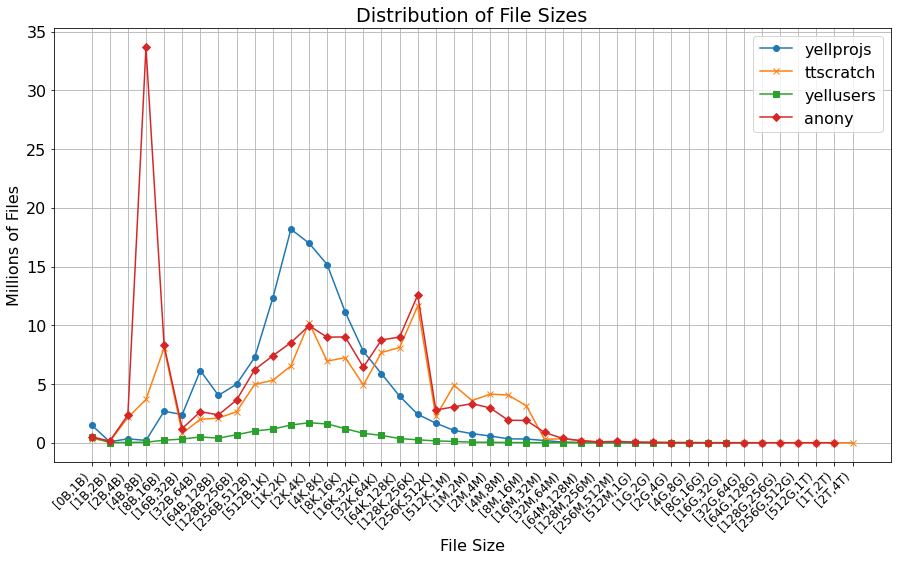

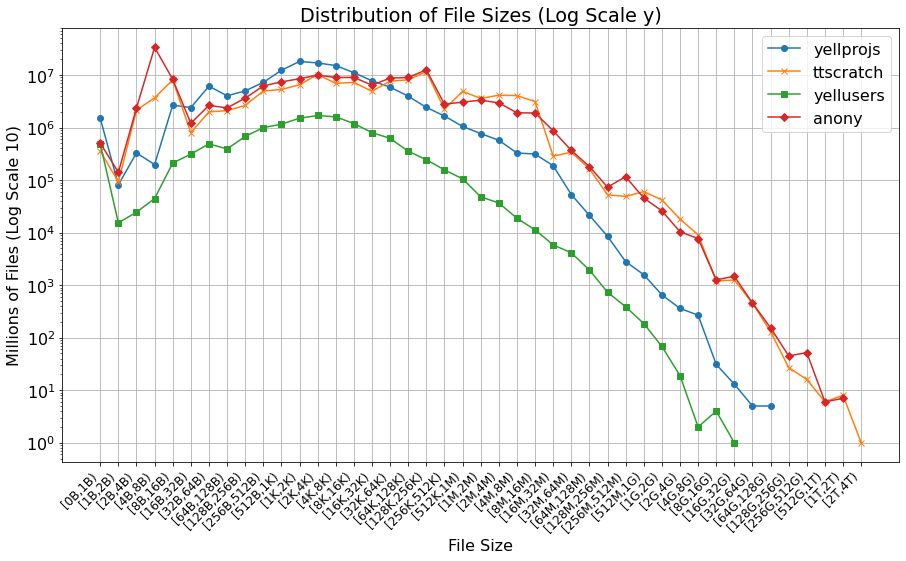

In [11]:
def frames_to_plt(dataframes,logscale=False):
    plt.figure(figsize=(15, 8))
    plt.rcParams['font.size'] = 16


    # Plot the data as a line graph
    markers = ['o', 'x', 's', 'D', '^', 'v']
    for idx, (indexroot, df) in enumerate(dataframes.items()):
        shortname = indexroot.rstrip('/').split("/")[-1]
        plt.plot(df['Range'], df['Num_Files'], marker=markers[idx], label=shortname)

    # y-tics are ugly, change them to be in values of millions
    def millions(x, pos):
        return f'{int(x/1e6)}'
    ax = plt.gca()
    formatter = FuncFormatter(millions)
    ax.yaxis.set_major_formatter(formatter)

    # Add labels and title
    plt.xlabel('File Size')
    plt.ylabel('Millions of Files')
    plt.title('Distribution of File Sizes')

    # avoid transparent background
    for item in (ax.figure, ax):
        item.set_facecolor('white')

    # Add grid and legend
    plt.grid(True)
    plt.legend()
    
    # x-axis is too crowded. Let's try to fix that.
    plt.xticks(rotation=45, ha='right')
    ax.tick_params(axis='x', labelsize=12)

    if logscale:
        # then add logscale and show it again
        ax.set_yscale('log')
        ax.set_title(ax.get_title() + " (Log Scale y)")
        ax.set_ylabel(ax.get_ylabel() + " (Log Scale 10)")
        
    return plt

plt = frames_to_plt(dataframes)
plt.show()
plt2 = frames_to_plt(dataframes,logscale=True)
plt2.show()